# ELO aplicado a los torneos de Pato

In [25]:
import pandas as pd
import numpy as np
import random

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.features import build_features
from src.tournaments import utilities
from src.visualization import visualize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:

data = pd.read_excel('../data/raw/data_pato_tournaments.xlsx', header=None,
                     names=['playerA1', 'playerA2', 'scoreA', 'vs', 'playerB1', 'playerB2', 'scoreB'])

data.head()

def get_result(row):
  if(row['scoreA'] > row['scoreB']):
    result = 1
  else:
    result = 0
  return result

data['result'] = data.apply (lambda row: get_result(row), axis=1)

## Preparando los datos

Primero seteamos que todos los jugadores tengan un ELO base de 1400

In [42]:
players_names = set(list(data['playerA1'])+list(data['playerA2'])+list(data['playerB1'])+list(data['playerB2']))
players = { i : [1400] for i in players_names }
players

{'Alejandro Vasquez': [1400],
 'Agustin Aldunate': [1400],
 'Jose Carvallo': [1400],
 'Alfonso Concha': [1400],
 'Rodrigo Holmberg': [1400],
 'Alonso Astroza': [1400],
 'Andres Abujatum': [1400],
 'Fernando Feres': [1400],
 'Patricio Roman': [1400],
 'Sergio Concha': [1400],
 'Rodrigo Zigante': [1400],
 'Daniel Vega': [1400]}

Procesamos los partidos de los dos torneos disponibles.

In [43]:
[build_features.update_ELO(players, row[0], row[1], row[2], row[3], row[4]) for row in zip(data['playerA1'], data['playerA2'], data['playerB1'], data['playerB2'], data['result'])]

['Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado',
 'Partido Procesado']

Entonces el ELO de cada jugador luego de los dos primeros torneos es el siguiente:

In [44]:
sorted([[name, elos[-1]] for name, elos in players.items()], key=lambda item: item[1], reverse=True)

[['Alejandro Vasquez', 1491.5124236742668],
 ['Patricio Roman', 1447.0633400934726],
 ['Andres Abujatum', 1443.887168202283],
 ['Alfonso Concha', 1442.0050605094439],
 ['Rodrigo Holmberg', 1440.9447914899001],
 ['Sergio Concha', 1430.8189309499837],
 ['Daniel Vega', 1419.6394519912478],
 ['Alonso Astroza', 1361.476543040606],
 ['Jose Carvallo', 1358.7589199060117],
 ['Fernando Feres', 1358.7589199060117],
 ['Agustin Aldunate', 1304.8902432537302],
 ['Rodrigo Zigante', 1300.436731529382]]

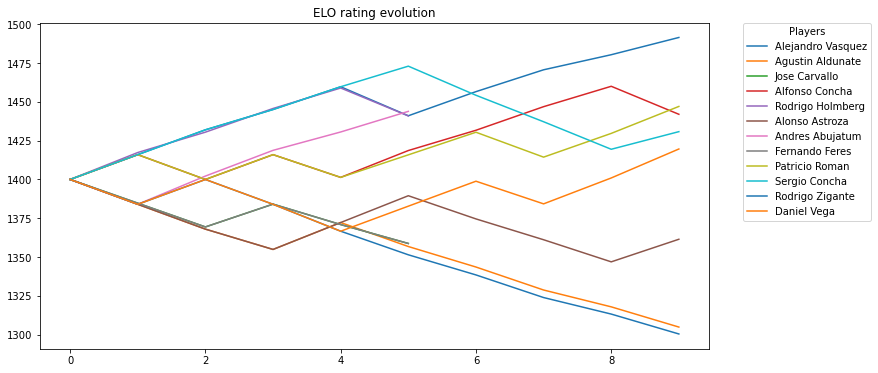

In [28]:
visualize.plot_elo_rating(players, 'ELO rating evolution')

## Simulando Torneos

### Como se define una dupla ganadora al azar

In [11]:
utilities.get_winner_team(players['Alejandro Vasquez'], players['Rodrigo Zigante'], players['Patricio Roman'], players['Agustin Aldunate'])

1

## Sistemas de Torneo

### Sistema A: Parejas fijas según ELO actual y se juega contra todas las otras parejas (5 rondas).

In [29]:
players_A = players.copy()
champs_A = []
points_totalA = dict.fromkeys(players_A, 0)
for k in range(1000):
  players_A = players.copy()
  players_names_sorted = sorted(players_A.items(), key=lambda item: item[1], reverse=True)
  teams = []
  nplayers = len(players_names_sorted)
  for i in range(6):
    teams.append([players_names_sorted[i][0], players_names_sorted[nplayers-i-1][0]])
  fixture = utilities.simulate_draw(teams)
  points_A = dict.fromkeys(players_A, 0)
  for m in fixture:
    r = utilities.get_winner_team(players_A[m[0][0]][-1], players_A[m[0][1]][-1], players_A[m[1][0]][-1], players_A[m[1][1]][-1])
    build_features.update_ELO(players_A, m[0][0], m[0][1], m[1][0], m[1][1], r)

    if r == 1:
      points_A[m[0][0]] += 1
      points_A[m[0][1]] += 1
      points_totalA[m[0][0]] += 1
      points_totalA[m[0][1]] += 1
    else:
      points_A[m[1][0]] += 1
      points_A[m[1][1]] += 1
      points_totalA[m[1][0]] += 1
      points_totalA[m[1][1]] += 1
  
  max_points = sorted(points_A.items(), key=lambda item: item[1], reverse=True)[0][1]
  champions = [name for name, points in points_A.items() if points == max_points]

  champs_A.append(champions)


In [30]:
from collections import Counter

Counter(x for xs in champs_A for x in set(xs))

Counter({'Agustin Aldunate': 259,
         'Jose Carvallo': 261,
         'Rodrigo Holmberg': 259,
         'Alonso Astroza': 248,
         'Andres Abujatum': 273,
         'Fernando Feres': 261,
         'Patricio Roman': 273,
         'Sergio Concha': 248,
         'Daniel Vega': 278,
         'Alfonso Concha': 278,
         'Alejandro Vasquez': 281,
         'Rodrigo Zigante': 281})

In [36]:
sorted(points_totalA.items(), key=lambda item: item[1], reverse=True)

[('Alfonso Concha', 2539),
 ('Daniel Vega', 2539),
 ('Alejandro Vasquez', 2532),
 ('Rodrigo Zigante', 2532),
 ('Andres Abujatum', 2528),
 ('Patricio Roman', 2528),
 ('Jose Carvallo', 2496),
 ('Fernando Feres', 2496),
 ('Agustin Aldunate', 2478),
 ('Rodrigo Holmberg', 2478),
 ('Alonso Astroza', 2427),
 ('Sergio Concha', 2427)]

In [32]:
points_total_normalizedA = {k: v / total for total in (sum(points_totalA.values())/2,) for k, v in points_totalA.items()}
sorted(points_total_normalizedA.items(), key=lambda item: item[1], reverse=True)

[('Alfonso Concha', 0.16926666666666668),
 ('Daniel Vega', 0.16926666666666668),
 ('Alejandro Vasquez', 0.1688),
 ('Rodrigo Zigante', 0.1688),
 ('Andres Abujatum', 0.16853333333333334),
 ('Patricio Roman', 0.16853333333333334),
 ('Jose Carvallo', 0.1664),
 ('Fernando Feres', 0.1664),
 ('Agustin Aldunate', 0.1652),
 ('Rodrigo Holmberg', 0.1652),
 ('Alonso Astroza', 0.1618),
 ('Sergio Concha', 0.1618)]

### Sistema B: Parejas dinámicas según ELO posterior a cada ronda, se juegan 5 rondas.

In [33]:
champsB = []
players_B = players.copy()
points_totalB = dict.fromkeys(players_B, 0)
for k in range(1000):
  players_B = players.copy()
  for j in range(5):
    players_names_sorted = sorted(players_B.items(), key=lambda item: item[1], reverse=True)
    teams = []
    nplayers = len(players_names_sorted)
    for i in range(6):
      teams.append([players_names_sorted[i][0], players_names_sorted[nplayers-i-1][0]])
    fixture = utilities.simulate_draw(teams)
    points_B = dict.fromkeys(players_B, 0)
    for m in fixture[0:3]:
      r = utilities.get_winner_team(players_B[m[0][0]][-1], players_B[m[0][1]][-1], players_B[m[1][0]][-1], players_B[m[1][1]][-1])
      build_features.update_ELO(players_B, m[0][0], m[0][1], m[1][0], m[1][1], r)

      if r == 1:
        points_B[m[0][0]] += 1
        points_B[m[0][1]] += 1
        points_totalB[m[0][0]] += 1
        points_totalB[m[0][1]] += 1
      else:
        points_B[m[1][0]] += 1
        points_B[m[1][1]] += 1
        points_totalB[m[1][0]] += 1
        points_totalB[m[1][1]] += 1
  
  max_points = sorted(points_B.items(), key=lambda item: item[1], reverse=True)[0][1]
  champions = [name for name, points in points_B.items() if points == max_points]

  champsB.append(champions)

In [34]:
from collections import Counter

Counter(x for xs in champsB for x in set(xs))

Counter({'Alejandro Vasquez': 496,
         'Jose Carvallo': 507,
         'Alonso Astroza': 507,
         'Fernando Feres': 507,
         'Sergio Concha': 507,
         'Rodrigo Zigante': 496,
         'Agustin Aldunate': 478,
         'Alfonso Concha': 524,
         'Rodrigo Holmberg': 478,
         'Daniel Vega': 524,
         'Andres Abujatum': 488,
         'Patricio Roman': 488})

In [35]:
points_total_normalizedB = {k: v / total for total in (sum(points_totalB.values())/2,) for k, v in points_totalB.items()}
sorted(points_total_normalizedB.items(), key=lambda item: item[1], reverse=True)

[('Alfonso Concha', 0.1704),
 ('Daniel Vega', 0.1704),
 ('Alonso Astroza', 0.16933333333333334),
 ('Sergio Concha', 0.16933333333333334),
 ('Andres Abujatum', 0.16806666666666667),
 ('Patricio Roman', 0.16806666666666667),
 ('Alejandro Vasquez', 0.16553333333333334),
 ('Rodrigo Zigante', 0.16553333333333334),
 ('Jose Carvallo', 0.16353333333333334),
 ('Fernando Feres', 0.16353333333333334),
 ('Agustin Aldunate', 0.16313333333333332),
 ('Rodrigo Holmberg', 0.16313333333333332)]

### Sistema C: Todo Random con Parejas Fijas

In [37]:
players_C = players.copy()
champs_C = []
points_totalC = dict.fromkeys(players_C, 0)
for k in range(1000):
  players_C = players.copy()
  players_names_sorted = sorted(players_C.items(), key=lambda item: item[1], reverse=True)
  random.shuffle(players_names_sorted)
  teams = []
  nplayers = len(players_names_sorted)
  for i in range(6):
    teams.append([players_names_sorted[i][0], players_names_sorted[nplayers-i-1][0]])
  fixture = utilities.simulate_draw(teams)
  points_C = dict.fromkeys(players_C, 0)
  for m in fixture:
    r = utilities.get_winner_team(players_C[m[0][0]][-1], players_C[m[0][1]][-1], players_C[m[1][0]][-1], players_C[m[1][1]][-1])
    build_features.update_ELO(players_C, m[0][0], m[0][1], m[1][0], m[1][1], r)

    if r == 1:
      points_C[m[0][0]] += 1
      points_C[m[0][1]] += 1
      points_totalC[m[0][0]] += 1
      points_totalC[m[0][1]] += 1
    else:
      points_C[m[1][0]] += 1
      points_C[m[1][1]] += 1
      points_totalC[m[1][0]] += 1
      points_totalC[m[1][1]] += 1
  
  max_points = sorted(points_C.items(), key=lambda item: item[1], reverse=True)[0][1]
  champions = [name for name, points in points_C.items() if points == max_points]

  champs_C.append(champions)


In [39]:
from collections import Counter

Counter(x for xs in champs_C for x in set(xs))

Counter({'Jose Carvallo': 258,
         'Rodrigo Holmberg': 299,
         'Patricio Roman': 274,
         'Alonso Astroza': 273,
         'Daniel Vega': 253,
         'Fernando Feres': 279,
         'Rodrigo Zigante': 292,
         'Sergio Concha': 254,
         'Andres Abujatum': 292,
         'Agustin Aldunate': 276,
         'Alfonso Concha': 282,
         'Alejandro Vasquez': 258})

In [40]:
points_total_normalizedC = {k: v / total for total in (sum(points_totalC.values())/2,) for k, v in points_totalC.items()}
sorted(points_total_normalizedC.items(), key=lambda item: item[1], reverse=True)

[('Rodrigo Zigante', 0.16913333333333333),
 ('Rodrigo Holmberg', 0.1688),
 ('Fernando Feres', 0.168),
 ('Patricio Roman', 0.16753333333333334),
 ('Alonso Astroza', 0.1672),
 ('Daniel Vega', 0.1666),
 ('Andres Abujatum', 0.16613333333333333),
 ('Agustin Aldunate', 0.16573333333333334),
 ('Jose Carvallo', 0.16573333333333334),
 ('Alejandro Vasquez', 0.1656),
 ('Alfonso Concha', 0.1654),
 ('Sergio Concha', 0.16413333333333333)]

## Comparación

In [ ]:
puntos_pobA = [points for name, points in points_totalA.items()]
puntos_pobB = [points for name, points in points_totalB.items()]

In [ ]:
puntos_pobA

[2480, 2483, 2483, 2480, 2493, 2528, 2510, 2506, 2528, 2493, 2510, 2506]

In [ ]:
puntos_pobB

[2570, 2506, 2521, 2478, 2548, 2456, 2462, 2456, 2463, 2525, 2483, 2532]

(array([0.06944444, 0.        , 0.03472222, 0.        , 0.        ,
        0.03472222, 0.03472222, 0.        , 0.        , 0.03472222]),
 array([2480. , 2484.8, 2489.6, 2494.4, 2499.2, 2504. , 2508.8, 2513.6,
        2518.4, 2523.2, 2528. ]),
 <a list of 10 Patch objects>)

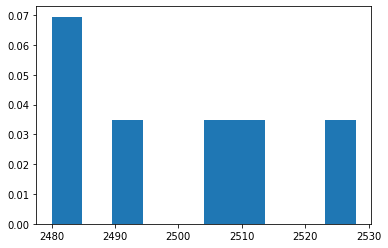

In [ ]:
import matplotlib.pyplot as plt
plt.hist(puntos_pobA, density=True)

(array([0.02923977, 0.00730994, 0.00730994, 0.        , 0.00730994,
        0.00730994, 0.01461988, 0.        , 0.00730994, 0.00730994]),
 array([2456. , 2467.4, 2478.8, 2490.2, 2501.6, 2513. , 2524.4, 2535.8,
        2547.2, 2558.6, 2570. ]),
 <a list of 10 Patch objects>)

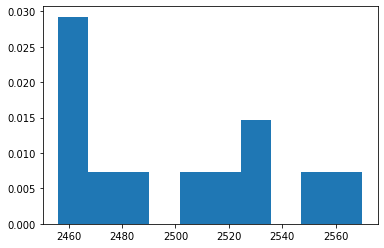

In [ ]:
plt.hist(puntos_pobB, density=True)